In [1]:
import cv2
import SUNRGBD
import random as rand
import pandas as pd
import numpy as np
import json
import os
import shutil
import sys
import h5py
import scipy.io

In [2]:
path_to_sun = "./../../SUNRGBD/"

In [3]:
%pwd

'/Users/evinpinar/Documents/Classes/THESIS/planercnn/sun'

In [4]:
store = []
for f in os.listdir(path_to_sun):
    if not f.startswith('.'):
        store.append(f)

In [5]:
store

['test', 'kv1', 'xtion', 'train', 'kv2', 'realsense']

In [6]:
store = ['kv1', 'xtion','kv2', 'realsense']

In [7]:
b = []
for i in range(len(store)):
    for f in os.listdir(path_to_sun + store[i]):
        if not f.startswith('.'):
            b.append(path_to_sun + store[i] + "/" + f + "/")
store = []

c = []
for i in range(len(b)):
    if b[i] != (path_to_sun + "xtion/sun3ddata/"):
        for f in os.listdir(b[i]):
            if not f.startswith('.'):
                store.append(b[i]  + f + "/")
    else:
        for f in os.listdir(b[i]):
            if not f.startswith('.'):
                c.append(b[i]  + f + "/")

In [8]:
for i in range(len(c)):
    for f in os.listdir(c[i]):
        if not f.startswith('.'):
            for r in os.listdir(c[i]  + f + "/"):
                if not r.startswith('.'):
                    store.append(c[i]  + f + "/" + r + "/")

In [9]:
#just excluded
#'/Users/ekaterina/Desktop/diploma/mask_rcnn/datasets/SUNRGBD/kv2/kinect2data/000667_2014-06-09_21-06-12_260595134347_rgbf000145-resize/'
#checking that we collected all the pictures
len(store)

10335

In [35]:
#The standdard trainval-test split uses the first 5050 images for testing and the rest for trainval.
if not os.path.exists((path_to_sun + "test") or (path_to_sun + "train")):
    os.makedirs(path_to_sun + "test")
    os.makedirs(path_to_sun + "train")
if not os.path.exists((path_to_sun + "train" + "/train") or (path_to_sun + "train"+ "/val")):
    os.makedirs(path_to_sun + "train" + "/train")
    os.makedirs(path_to_sun + "train"+ "/val")

In [11]:
store[0]

'./../../SUNRGBD/kv1/NYUdata/NYU0428/'

In [14]:
np.save("store_data", np.array(store))

In [16]:
np.array(store).shape

(10335,)

# Work with a class mapping

In [8]:
import pandas as pd
import scipy.io

mat = scipy.io.loadmat('classMapping40.mat')

label_13 = [1,2,3,4,5,6,7,8,9,10,11,12,13]
name_13 = ["bed", "books", "ceiling", 
                 "chair", "floor", "furniture", 
                 "objects", "picture", "sofa", 
                 "table", "tv", "wall", "window"]

labels_13 = pd.DataFrame({
     'label_13': label_13,
     'name_13': name_13})

In [9]:
list_of_40 = []
for i in range(0, len(mat["className"][0])):
    list_of_40.append(mat["className"][0][i][0]) 
    
label_of_40 = list(range(1,41))
merging = [12,5,6,1,4,9,10,12,13,6,8,6,13,10,6,13,6,7,7,5,7,3,2,6,11,7,7,7,7,7,7,6,7,7,7,7,7,7,6,7]

labels_40 = pd.DataFrame({
     'Label_40': label_of_40,
     'Name_40': list_of_40,
     "label_13": merging})

In [10]:
allClassName_894 = []
for i in range(0, len(mat["allClassName"][0])):
    allClassName_894.append(mat["allClassName"][0][i][0])

mapClass_894 = []
for i in range(0, len(mat["mapClass"][0])):
    mapClass_894.append(mat["mapClass"][0][i])
    
labels_894 = pd.DataFrame({
     'Label_40': list(mapClass_894),
     'Name_894': list(allClassName_894)})

In [11]:
df = pd.read_csv('name_mapping_from_toolbox')
df = df.drop(['Unnamed: 0'], axis=1)
df = pd.merge(df, labels_40, left_on="Label_37", right_on="Label_40").drop([ 'Label_37', 'Name_37'], axis=1)

In [12]:
print(labels_894.loc[labels_894['Name_894'] == 'book'])
df3 = pd.merge(labels_894, labels_40)
final_dataset = pd.merge(df3, labels_13)

   Label_40 Name_894
0        40     book


In [13]:
labels_needed = {}
#Converting data to work with 13 classes
for i in range(0, len(df)):
    labels_needed[str(df.iloc[i]['Name_6585'])] = df.iloc[i]['label_13']
    
# Adding data for the dun from matlab file
#Converting data to work with 13 classes
for i in range(0, len(final_dataset)):
    labels_needed[str(final_dataset.iloc[i]['Name_894'])] = final_dataset.iloc[i]['label_13']

# Start the parsing

In [14]:
all_labels = []
for key in labels_needed.keys():
    all_labels.append(key)

In [15]:
import stringdist

ufo = {}
def transformation(image_root, number_of_image):
    # Set the paths
    image_root = image_root
    path_to_image = image_root + "image/" + (os.listdir(image_root + "/image/")[0])
    anotation = image_root + 'annotation2Dfinal'
    
    with open(anotation + "/index.json") as data_file:
        data = json.load(data_file)
    
    numberOfAnot = len(data["frames"][0]["polygon"])
    element = {}

    size =  os.path.getsize(path_to_image)
    filename = os.listdir(image_root + "/image")
    filename = filename[0]

    element = {"fileref": '', "size": size, 
        "filename": str(number_of_image) + ".jpg", 'base64_img_data': '', 'file_attributes': {}, 'regions': {}}
    
    anootation2D = []
    labels2D = []
    regions = {}
    
    for i in range(0, numberOfAnot):
        x = data["frames"][0]["polygon"][i]["x"]
        y = data["frames"][0]["polygon"][i]["y"]
        idxObj = data["frames"][0]["polygon"][i]["object"]
        if idxObj <= len(data['objects']):
            label = data['objects'][idxObj]["name"].lower()
            label = ''.join(i for i in label if not i.isdigit())
            if label in labels_needed:
                label = labels_needed[label]
            else:
                leve = {}
                for i in range(0,len(all_labels)):
                    leve[all_labels[i]] = stringdist.levenshtein(label, all_labels[i])
                label = labels_needed[min(leve, key=leve.get)]
                ufo[min(leve, key=leve.get)] = label
            if type(x) == list and type(y) == list:
                all_points_x = list(map(round, x))
                all_points_y = list(map(round, y))
                if len(all_points_y) != 0 and len(all_points_x) != 0:
                    shape_attributes = {'name':'polygon',"all_points_x":x,"all_points_y":y}
                    region = {'shape_attributes': {'name': 'polygon',
                    'all_points_x': x, 'all_points_y': y}, 'region_attributes': {"class": int(label)}}  
                    element['regions'][str(i)] = region
    return element

In [39]:
store[1][3:]

'./../SUNRGBD/kv1/NYUdata/NYU0870/'

## Matlab connection

In [53]:
import matlab.engine
import skimage.color
import skimage.io as io
import matplotlib.pyplot as plt

In [18]:
eng = matlab.engine.start_matlab()

In [19]:
eng.addpath(r'/Users/evinpinar/Documents/Classes/THESIS/indoor_scene_seg_sup/rgb_plane2rgb_world.m',nargout=0)
eng.addpath(r'/Users/evinpinar/Documents/Classes/THESIS/indoor_scene_seg_sup/extract_surface_normals.m',nargout=0)
eng.addpath(r'/Users/evinpinar/Documents/Classes/THESIS/indoor_scene_seg_sup',nargout=0)
eng.addpath(r'/Users/evinpinar/Documents/Classes/THESIS/indoor_scene_seg_sup/',nargout=0)
eng.addpath(r'/Users/evinpinar/Documents/Classes/THESIS/indoor_scene_seg_sup/common/',nargout=0)
eng.addpath(r'/Users/evinpinar/Documents/Classes/THESIS/indoor_scene_seg_sup/surfaces/',nargout=0)

In [36]:
path_to_image = store[1] + "depth_bfx/" + (os.listdir(store[1] + "/depth_bfx/")[0])
path_to_image

'./../../SUNRGBD/kv1/NYUdata/NYU0870/depth_bfx/NYU0870.png'

In [21]:
target_dir = path_to_sun + "train/train/"

In [22]:
img = io.imread(path_to_image)

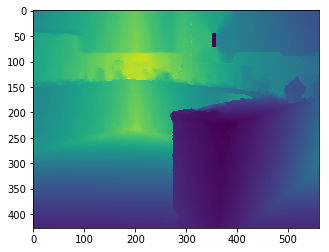

In [23]:
plt.imshow(img)

In [24]:
img.shape

(427, 561)

In [25]:
len(img.tolist()), len(img.tolist()[0])

(427, 561)

In [26]:
A = matlab.double(img.tolist())

In [27]:
img.astype(np.double).dtype

dtype('float64')

In [31]:
with open(store[i]+ "/intrinsics.txt", 'r') as f:
    x = f.read().replace('\n', ' ').split(" ")[:9]
    x = [float(i) for i in x]
    fx_rgb = x[0]
    fy_rgb = x[4]
    cx_rgb = x[2]
    cy_rgb = x[5]

In [32]:
points3d = eng.rgb_plane2rgb_world(A, fx_rgb, fy_rgb, cx_rgb, cy_rgb)

In [33]:
x = eng.try_it()

In [34]:
np.asarray(points3d).shape

(239547, 3)

In [37]:
imgNormals = eng.extract_surface_normals(A, fx_rgb, fy_rgb, cx_rgb, cy_rgb)

In [38]:
np.asarray(imgNormals).shape

(530, 730, 3)

In [46]:
%pwd

'/Users/evinpinar/Documents/Classes/THESIS/planercnn/sun'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


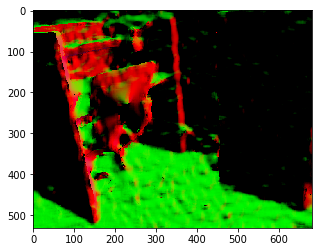

In [246]:
import scipy.io
import os
mat = scipy.io.loadmat('./../../indoor_scene_seg_sup/surface_normals_train/normals_001742.mat')
normals = mat['imgNormals']
#k = normals.astype(np.float32)
plt.imshow(normals)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


float64


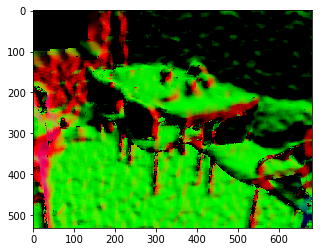

In [193]:
pl = np.load('/Users/evinpinar/Documents/Classes/THESIS/train/train/6790_plane.npy')
print(pl.dtype)
plt.imshow(pl)

uint8


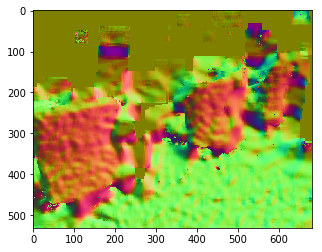

In [256]:
pl = np.load('./../../plane_data/train/train/6787_plane.npy')
print(pl.dtype)
plt.imshow(pl)

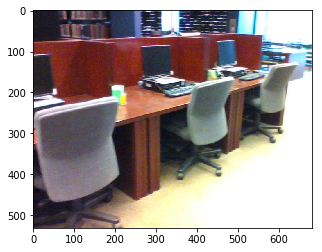

In [257]:
i = 6787
file_name = os.listdir(store[i] + "image")[0]
file_to_copy = store[i] + "image/" + file_name
img = io.imread(file_to_copy)
plt.imshow(img)

In [ ]:
train_files = os.listdir("./../../indoor_scene_seg_sup/surface_normals_train")
train_files = sorted(train_files)
ext = './../../indoor_scene_seg_sup/surface_normals_train/'
train_files = [ext+x for x in train_files]

In [196]:
plane_files = os.listdir("./../../train/train")
plane_files = sorted(plane_files)
ext = "./../../train/train/"
plane_files = [ext+x for x in plane_files]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


float64


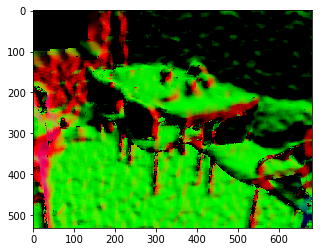

In [237]:
pl = np.load(plane_files[-1])
print(pl.dtype)
plt.imshow(pl)

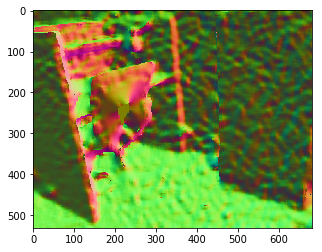

In [247]:
plane = normals
plane += np.abs(np.min(plane))
plane /= np.max(plane)
plt.imshow(plane)

In [234]:
target_dir = './../../plane_data/train/train/'
i = 5050
np.save(target_dir + str(i) + '_plane', plane)

In [232]:
plane += np.abs(np.min(plane))
plane /= np.max(plane)
plane *= (255.0/plane.max())
plane = plane.astype(np.uint8)

In [235]:
i = 5050
target_dir = './../../plane_data/train/train/'
for f in plane_files:
    plane = np.load(f)
    plane += np.abs(np.min(plane))
    plane /= np.max(plane)
    plane *= (255.0/plane.max())
    plane = plane.astype(np.uint8)
    np.save(target_dir + str(i) + '_plane', plane)
    i+=1

In [258]:
val_files = os.listdir("./../../indoor_scene_seg_sup/surface_normals_val")
val_files = sorted(val_files)
ext = './../../indoor_scene_seg_sup/surface_normals_val/'
val_files = [ext+x for x in val_files]

In [259]:
val_files[:5]

['./../../indoor_scene_seg_sup/surface_normals_val/normals_000001.mat',
 './../../indoor_scene_seg_sup/surface_normals_val/normals_000002.mat',
 './../../indoor_scene_seg_sup/surface_normals_val/normals_000003.mat',
 './../../indoor_scene_seg_sup/surface_normals_val/normals_000004.mat',
 './../../indoor_scene_seg_sup/surface_normals_val/normals_000005.mat']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


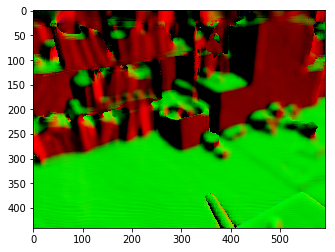

In [264]:
mat = scipy.io.loadmat(val_files[0])
plane = mat['imgNormals']
plt.imshow(plane)

In [267]:
len(val_files)

1057

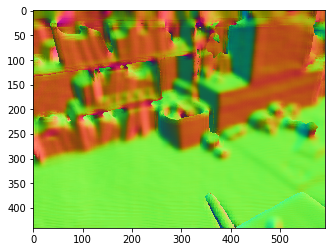

In [265]:
plane += np.abs(np.min(plane))
plane /= np.max(plane)
plane *= (255.0/plane.max())
plane = plane.astype(np.uint8)
plt.imshow(plane)

In [271]:
i = 9276
target_dir = './../../plane_data/train/val/'
for f in val_files:
    try:
        mat = scipy.io.loadmat(f)
        plane = mat['imgNormals']
        plane += np.abs(np.min(plane))
        plane /= np.max(plane)
        plane *= (255.0/plane.max())
        plane = plane.astype(np.uint8)
        np.save(target_dir + str(i) + '_plane', plane)
    except:
        print("failed: i")
    i+=1

In [272]:
i

10333

### Start extraction

In [ ]:
import csv


# For the NYU dataset
# 80% of train images - 1160 pics (0, 1160)
   # 10% test - 145 pics (1160,1305)
   # 10: validation - 144 pics (1305, 1449)
# 20% of test images - 289

# 5050 test images store[0 : 5049]
# 5285 train-val images [5050 : 10334]
   # 4226 train images [5050:9275]
   # 1056 validation images [9276: 10333]
d = {}
fail = []
# Working with a test dataset - 5050 images
with open('train_file.csv', mode='w') as train_file:
    train_writer = csv.writer(train_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    for i in range(5050, 9275):
        file_name = os.listdir(store[i] + "image")[0]
        file_to_copy = store[i] + "image/" + file_name
        target_dir = path_to_sun + "train/train/"
        #shutil.copyfile(file_to_copy, target_dir + str(i) + ".jpg")

        depth_file_name = os.listdir(store[i] + "/depth_bfx")[0]
        depth_file_to_copy = store[i] + "depth_bfx/" + depth_file_name
        depth_target_dir = path_to_sun + "train/train/"
        print(depth_file_to_copy[3:])
        #shutil.copyfile(depth_file_to_copy, depth_target_dir + str(i) + "_depth.png")

        with open(store[i]+ "/intrinsics.txt", 'r') as f:
            x = f.read().replace('\n', ' ').split(" ")[:9]
            x = [float(i) for i in x]
            fx_rgb = x[0]
            fy_rgb = x[4]
            cx_rgb = x[2]
            cy_rgb = x[5]

        #print(fx_rgb, cx_rgb)
        train_writer.writerow([depth_file_to_copy[3:], fx_rgb, fy_rgb, cx_rgb, cy_rgb])


In [ ]:
    '''
    try:
        plane_file = target_dir + str(i) + "_plane"
        depth = skimage.io.imread(depth_file_to_copy)
        # points = rgb_plane2rgb_world(depth, fx_rgb, fy_rgb, cx_rgb, cy_rgb)
        print(depth.shape)
        A = matlab.double(depth.tolist())
        #points3d = eng.rgb_plane2rgb_world(A, fx_rgb, fy_rgb, cx_rgb, cy_rgb)
        #print(np.asarray(points3d).shape)
        imgNormals = eng.extract_surface_normals(A, fx_rgb, fy_rgb, cx_rgb, cy_rgb)
        normals = np.asarray(imgNormals)
        np.save(plane_file, normals)
    except Exception as e:
        print(e)
        print("Fuckup with "+ str(i))
        
    if i%100==0:
        print(i)
    '''

In [16]:
print("Pictures failed:" + str(len(fail)))
print("Pictures parsed:" + str(len(d)))

Pictures failed:0
Pictures parsed:1160


In [ ]:
ufo

In [ ]:
with open('test_file.csv', mode='w') as train_file:
    train_writer = csv.writer(train_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    for i in range(0, 5049):
        file_name = os.listdir(store[i] + "image")[0]
        file_to_copy = store[i] + "image/" + file_name
        target_dir = path_to_sun + "test/"
        #shutil.copyfile(file_to_copy, target_dir + str(i) + ".jpg")

        depth_file_name = os.listdir(store[i] + "/depth_bfx")[0]
        depth_file_to_copy = store[i] + "depth_bfx/" + depth_file_name
        depth_target_dir = path_to_sun + "test/"
        #print(depth_file_to_copy[3:])
        #shutil.copyfile(depth_file_to_copy, depth_target_dir + str(i) + "_depth.png")

        with open(store[i]+ "/intrinsics.txt", 'r') as f:
            x = f.read().replace('\n', ' ').split(" ")[:9]
            x = [float(i) for i in x]
            fx_rgb = x[0]
            fy_rgb = x[4]
            cx_rgb = x[2]
            cy_rgb = x[5]

        #print(fx_rgb, cx_rgb)
        train_writer.writerow([depth_file_to_copy[3:], fx_rgb, fy_rgb, cx_rgb, cy_rgb])

In [19]:
print("Pictures failed:" + str(len(fail2)))
print("Pictures parsed:" + str(len(d2)))

Pictures failed:0
Pictures parsed:145


In [ ]:

with open('val_file.csv', mode='w') as train_file:
    train_writer = csv.writer(train_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    for i in range(9276, 10333):
        file_name = os.listdir(store[i] + "image")[0]
        file_to_copy = store[i] + "image/" + file_name
        target_dir = path_to_sun + "train/val/"
        #shutil.copyfile(file_to_copy, target_dir + str(i) + ".jpg")

        depth_file_name = os.listdir(store[i] + "/depth_bfx")[0]
        depth_file_to_copy = store[i] + "depth_bfx/" + depth_file_name
        depth_target_dir = path_to_sun + "train/val/"
        #print(depth_file_to_copy[3:])
        #shutil.copyfile(depth_file_to_copy, depth_target_dir + str(i) + "_depth.png")

        with open(store[i]+ "/intrinsics.txt", 'r') as f:
            x = f.read().replace('\n', ' ').split(" ")[:9]
            x = [float(i) for i in x]
            fx_rgb = x[0]
            fy_rgb = x[4]
            cx_rgb = x[2]
            cy_rgb = x[5]

        #print(fx_rgb, cx_rgb)
        train_writer.writerow([depth_file_to_copy[3:], fx_rgb, fy_rgb, cx_rgb, cy_rgb])
        

In [21]:
print("Pictures failed:" + str(len(fail3)))
print("Pictures parsed:" + str(len(d3)))

Pictures failed:0
Pictures parsed:144


In [22]:
image_root = store[100]

In [23]:
frameData = SUNRGBD.readFrame(image_root, True )

In [24]:
import matplotlib.pyplot as plt
imgRGBWithAnnotations = np.array(frameData.imgRGB, copy=True)

for i in range(0, len(frameData.annotation2D)):
    color = [rand.randint(0,255), rand.randint(0,255), rand.randint(0,255)]
    cv2.fillPoly(imgRGBWithAnnotations, [frameData.annotation2D[i]], color)
    
for i in range(0, len(frameData.annotation2D)):
    data = frameData.annotation2D[i];
    centroid = np.mean(data,axis=0)
    cv2.putText(imgRGBWithAnnotations, frameData.labels2D[i], (int(centroid[0]), int(centroid[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.7, [0,0,0],2)
    

In [25]:
data = frameData.annotation2D
data2 = frameData.labels2D

In [26]:
anotation2D = image_root + "/annotation2Dfinal/index.json"

with open(anotation2D) as data_file:    
    data = json.load(data_file)

    numberOfAnot = len(data["frames"][0]["polygon"]);
    anootation2D = [];
    labels2D = [];
    for i in range(0,numberOfAnot):
        x = data["frames"][0]["polygon"][i]["x"]
        y = data["frames"][0]["polygon"][i]["y"]

        idxObj = data["frames"][0]["polygon"][i]["object"];
        pts2 = np.array([x,y], np.int32)
        pts2 = np.transpose(pts2);
        anootation2D.append(pts2);
        labels2D.append(data['objects'][idxObj]["name"])

Depth data


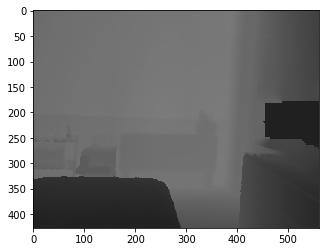

In [27]:
print("Depth data")
plt.imshow(frameData.imgD);

RGB Image


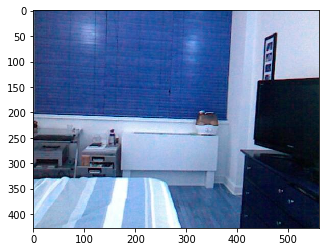

In [28]:
print("RGB Image")
plt.imshow(frameData.imgRGB);

Annotated Image


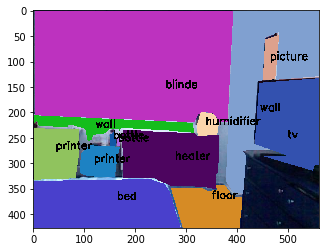

In [29]:
print("Annotated Image")
plt.imshow(imgRGBWithAnnotations);